# GMM water mass classification

In [1]:
# import sys
# sys.path.append('/Users/dge105/Dropbox/Python_modules')

import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.dates as mdates
import matplotlib
import datetime
import numpy as np
import cmocean
import pickle
import gsw
import seawater as sw
import numpy_groupies as npg
import cartopy.crs as ccrs
import os

from wmt import bin_3D_field_2D
from wmt import calc_tot_trans
from wmt import calc_grid_vol

from sklearn import preprocessing
from sklearn import mixture

from matplotlib import gridspec
from matplotlib import cm

from scipy.interpolate import RegularGridInterpolator as rgi
from scipy.interpolate import griddata

In [2]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

## Define GMM analysis functions

### Define the training dataset and normalise the data

In [3]:
def FlattenSmooth(ts_var, time, ts_var_nodata, rmean, calclog):
    
    # Flatten 3D array, remove zeros (interpolating between) and take the log of volume
    ts_var_array = ts_var.copy()
    ts_var_flat = ts_var_array.reshape(np.shape(ts_var_array)[0] * np.shape(ts_var_array)[1], np.shape(ts_var_array)[2])
    ts_var_flat = ts_var_flat[ts_var_nodata.flatten(), :]

    ts_var_flat_no0 = np.zeros(np.shape(ts_var_flat))

    for ii in np.arange(0, np.shape(ts_var_flat)[0]):
        ts_timeseries = ts_var_flat[ii, :][ts_var_flat[ii, :] != 0]
        dats = time[ts_var_flat[ii, :] != 0]

        ts_var_flat_no0[ii, :] = np.interp(time, dats, ts_timeseries)

    ########################
    
    if rmean:
        # Caculate running mean

        da = xr.DataArray(ts_var_flat_no0,
                         dims=('x', 'time'),
                         coords={'time': dset.time})

        r = da.rolling(time=n_months, center=True)
        r_mean = r.mean().dropna('time')

        ts_var_flat_no0_smth = r_mean.data              
        ts_var_time = mdates.date2num(r_mean['time'])
        
        if calclog:
            ts_var_flat_no0_log = np.log10(ts_var_flat_no0_smth)
        else:
            ts_var_flat_no0_log = ts_var_flat_no0_smth       
        
    else:

        # Don't calculate running mean

        if calclog:
            ts_var_flat_no0_log = np.log10(ts_var_flat_no0)
        else:
            ts_var_flat_no0_log = ts_var_flat_no0     
        
        ts_var_time = time
     
    return ts_var_flat_no0_log, ts_var_time, ts_var_flat_no0
    ########################

def NormVar(ts_var_flat_no0_log, select, norm_type):
    
    if norm_type == 'ts':
        # Try using sklearn.preprocessing, fit calculates the mean and std, and transform standardises

        ts_var_train = ts_var_flat_no0_log[select, :]

        stand = preprocessing.StandardScaler()
        stand.fit(ts_var_train)
        ts_var_norm = stand.transform(ts_var_train) # Training dataset
        ts_var_norm_full = stand.transform(ts_var_flat_no0_log) # Full dataset

    ########################
    
    elif norm_type == 'time':
        # After chatting with G. Maze he suggested normalising in time, it looked like the GMM was selecting by volume
        # Try this here...
        # Caveat can only calculate statistics on the whole dataset and then select the training dataset

        ts_var_mean = np.expand_dims(np.nanmean(ts_var_flat_no0_log, axis=1), axis=1)
        ts_var_std = np.expand_dims(np.nanstd(ts_var_flat_no0_log, axis=1), axis=1)

        ts_var_norm_full = (ts_var_flat_no0_log - ts_var_mean) / ts_var_std

        ts_var_norm = ts_var_norm_full[select, :]

    return ts_var_norm_full, ts_var_norm
    ########################
    
    
def pre_GMM(*args, **kwargs):

    ########################
    # pre_GMM(ts_var, time, dep_cut_off, n_data_cut_off, tr_dset_frac, fig_dir, gmm_var_name, n_months, WeightVar, rmean=True,  plot=True, norm_type='ts', calclog=True, weightit=True, norm_type_weight='ts')
    ########################
    
    ts_var = args[0]
    time = args[1]
    dep_cut_off = args[2]
    n_data_cut_off = args[3]
    tr_dset_frac = args[4]
    fig_dir = args[5]
    gmm_var_name = args[6]
    
    rmean = kwargs['rmean']
    weightit = kwargs['weightit']
    
    if rmean & weightit:
        n_months = args[7]
        WeightVar = args[8]
        norm_type_weight=kwargs['norm_type_weight']
    elif rmean & ~weightit: 
        n_months = args[7]
    elif ~rmean & weightit: 
        WeightVar = args[7]
        norm_type_weight=kwargs['norm_type_weight']
        
    plot = kwargs['plot']
    norm_type = kwargs['norm_type']
    calclog = kwargs['calclog']
    
    ########################

    # Select TS bins with mean depth that is within a certain range 

    ts_dep_cut_idx = (np.nanmean(ts_vol['ts_dep'], axis=2) > dep_cut_off[0]) & (np.nanmean(ts_vol['ts_dep'], axis=2) < dep_cut_off[1])

    ########################

    # Select the depth layer(s) here and...
    # Only select T/S bins that have a volume for a set fraction of the time-series given by "cut_off"

    ts_var_nodata = (np.sum(ts_var==0, axis=2) / len(time) < n_data_cut_off) & ts_dep_cut_idx

    ########################
    
    # Flatten and smooth the data if specified
    ts_var_flat_no0_log, ts_var_time, ts_var_flat_no0 = FlattenSmooth(ts_var, time, ts_var_nodata, rmean, calclog)
    
    if weightit:
        ts_weight_flat_no0_log, ts_var_time, ts_weight_flat_no0 = FlattenSmooth(WeightVar, time, ts_var_nodata, rmean, False)
    
    # Select a subsample of the full dataset to calculate mean and std
    # Apparently you need to standardise the training dataset and use 
    # these statistics to standardise the full dataset.

    conc = np.int(np.floor(np.shape(ts_var_flat_no0_log)[0] * tr_dset_frac))
    select = np.random.randint(np.shape(ts_var_flat_no0_log)[0], size=conc)

    ########################

    # Normalise the data and apply weight
    ts_var_norm_full, ts_var_norm = NormVar(ts_var_flat_no0_log, select, norm_type)
    
    if weightit:
        ts_weight_norm_full, ts_weight_norm = NormVar(ts_weight_flat_no0_log, select, norm_type_weight)
        ts_var_norm_full = ts_var_norm_full + np.expand_dims(np.nanmean(ts_weight_norm_full, axis=1), axis=1)
        ts_var_norm = ts_var_norm + np.expand_dims(np.nanmean(ts_weight_norm, axis=1), axis=1)
#         ts_var_norm_full = ts_var_norm_full + ts_weight_norm_full
#         ts_var_norm = ts_var_norm + ts_weight_norm
        
    # Bin to display the PDF of data
    anom_bin = 500
    ts_var_pdf_t = np.zeros((anom_bin, np.shape(ts_var_norm)[1]))

    for ii in np.arange(0, np.shape(ts_var_norm)[1]):

        out = np.histogram(ts_var_norm[:, ii], bins=anom_bin)
        ts_var_pdf_t[:, ii] = out[0]

    amon_bin_mid = out[1]
    
    ########################
    
    if plot:
    
        fig = plt.figure(figsize=(15, 10))
        gs = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[0.7,1])

        ax1 = plt.subplot(gs[0])
        ax2 = plt.subplot(gs[1])

        for ii in np.arange(0, np.shape(ts_var_norm)[0], 1):
            ax1.plot(ts_var_time, ts_var_norm[ii, :], color=[0.5, 0.5, 0.5], linewidth=0.1)

        c_lim = (0, 10)
        cs = ax2.pcolormesh(ts_var_time, amon_bin_mid, (ts_var_pdf_t), cmap=cmocean.cm.amp, vmin=c_lim[0], vmax=c_lim[1])
                # ax.set_yscale('log')
                # ax.set_ylim(1e-2, 1e16)
        cbar = fig.colorbar(cs, orientation='horizontal', shrink=0.7)
        
        if rmean:
            ax1.set_title('EN4_' + gmm_var_name + '_norm_dep{:1.0f}_{:1.0f}_rmean_{:1.0f}_months'.format(dep_cut_off[0], dep_cut_off[1], n_months))
            outfile = os.path.expanduser(fig_dir + 'EN4_' + gmm_var_name + '_norm_dep{:1.0f}_{:1.0f}_rmean_{:1.0f}_months.png').format(dep_cut_off[0], dep_cut_off[1], n_months)
        else:
            ax1.set_title('EN4_' + gmm_var_name + '_norm_dep{:1.0f}_{:1.0f}_rmean'.format(dep_cut_off[0], dep_cut_off[1]))
            outfile = os.path.expanduser(fig_dir + 'EN4_' + gmm_var_name + '_norm_dep{:1.0f}_{:1.0f}.png').format(dep_cut_off[0], dep_cut_off[1])
                
        plt.savefig(outfile, dpi=300, bbox_inches='tight')
    
    for_gmm = None
    
    if rmean:    
        for_gmm = \
        {'full_dataset': ts_var_norm_full.copy(), 'training_dataset': ts_var_norm.copy(), 'unproc_dataset':ts_var_flat_no0.copy(), 'time': ts_var_time.copy(), 'unproc_time': time, \
         'no_data': ts_var_nodata.copy(), 'dep_cut_off': dep_cut_off.copy(), 'rmean': True, 'n_months': n_months, 'gmm_var_name': gmm_var_name}
    else:                                     
        for_gmm = \
        {'full_dataset': ts_var_norm_full.copy(), 'training_dataset': ts_var_norm.copy(), 'unproc_dataset':ts_var_flat_no0.copy(), 'time': ts_var_time.copy(), 'unproc_time': time, \
         'no_data': ts_var_nodata.copy(), 'dep_cut_off': dep_cut_off.copy(), 'rmean': False, 'gmm_var_name': gmm_var_name}

    return for_gmm


### Use BIC to select the best number of classes

In [4]:
import itertools

def run_BIC(for_gmm, fig_dir):
    
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 18)
    cv_types = ['spherical', 'tied', 'diag', 'full']

    gmm = None

    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type, tol = 1e-6, max_iter = 500, n_init=20)
            gmm.fit(for_gmm['training_dataset'])
            bic.append(gmm.bic(for_gmm['training_dataset']))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm

    bic = np.array(bic)
    color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                                  'darkorange'])
    clf = best_gmm
    bars = []

    # Plot the BIC scores
    plt.figure(figsize=(10, 5))
    spl = plt.subplot()
    for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
        xpos = np.array(n_components_range) + .2 * (i - 2)
        bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                      (i + 1) * len(n_components_range)],
                            width=.2, color=color))
    plt.xticks(n_components_range)
    plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
    
    if for_gmm['rmean']:
        plt.title('BIC score per model ' + for_gmm['gmm_var_name'] + ' dep{:1.0f}_{:1.0f}_rmean_{:1.0f}_months'.format(for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1], for_gmm['n_months']))
    else:
        plt.title('BIC score per model ' + for_gmm['gmm_var_name'] + ' dep{:1.0f}_{:1.0f}'.format(for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1]))
        
    xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
        .2 * np.floor(bic.argmin() / len(n_components_range))
    plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
    spl.set_xlabel('Number of components')
    spl.legend([b[0] for b in bars], cv_types)
    
    if for_gmm['rmean']:
        outfile = \
        os.path.expanduser(fig_dir + 'EN4_BIC_' + for_gmm['gmm_var_name'] + '_dep{:1.0f}_{:1.0f}_rmean_{:1.0f}_months.png').format(for_gmm['dep_cut_off'][0],for_gmm['dep_cut_off'][1],\
        for_gmm['n_months'])
    else:
        outfile = \
        os.path.expanduser(fig_dir + 'EN4_BIC_' + for_gmm['gmm_var_name'] + '_dep{:1.0f}_{:1.0f}.png').format(for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1])
                
    plt.savefig(outfile, dpi=300, bbox_inches='tight')

### Define GMM classes with the training dataset

In [5]:
def gmm_fit(for_gmm, n_comp, plot_col, fig_dir):

    cov_type = 'full'  # covariance type (full, tied, diag, or spherical)

    gmm = None
    gmm = mixture.GaussianMixture(n_components= n_comp, \
                                      covariance_type = cov_type, tol = 1e-6, max_iter = 500, n_init=20)

    gmm.fit(for_gmm['training_dataset'])

    weights = np.squeeze(gmm.weights_)  # shape (n_components)
    # note: "weights" is the same for each col_red
    means = np.squeeze(gmm.means_)  # shape (n_components, n_features)
    covariances = abs(np.squeeze(gmm.covariances_))  # shape (n_components, n_features) 

    fig, ax = plt.subplots(figsize=(15, 10))

    for ii in np.arange(0, np.shape(for_gmm['training_dataset'])[0], 1):
    #     ax.plot(ts_vol['time'], ts_vol_norm[ii, :], color=[0.25, 0.25, 0.25], linewidth=0.1)
        ax.plot(for_gmm['time'], for_gmm['training_dataset'][ii, :], color=[0.25, 0.25, 0.25], linewidth=0.1)

    for ii in np.arange(0, n_comp, 1):
    #     ax.plot(ts_vol['time'], means[ii, :], color=plot_col[ii])
        ax.plot(for_gmm['time'], means[ii, :], color=plot_col(ii))

    if for_gmm['rmean']:
        plt.title('GMM classes ' + for_gmm['gmm_var_name'] + ' nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}_rmean_{:1.0f}_months'.format(n_comp, for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1], for_gmm['n_months']))
    else:
        plt.title('GMM classes ' + for_gmm['gmm_var_name'] + ' nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}'.format(n_comp, for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1]))
        
    ax.set_facecolor('lightgray')
    
    if for_gmm['rmean']:
        outfile = \
        os.path.expanduser(fig_dir + 'EN4_GMM_' + for_gmm['gmm_var_name'] + '_tr_nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}_rmean_{:1.0f}_months.png').format(n_comp, for_gmm['dep_cut_off'][0],for_gmm['dep_cut_off'][1],\
        for_gmm['n_months'])
    else:
        outfile = \
        os.path.expanduser(fig_dir + 'EN4_GMM_' + for_gmm['gmm_var_name'] + '_tr_nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}.png').format(n_comp, for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1])
                
    plt.savefig(outfile, dpi=300, bbox_inches='tight')
    
    return gmm

### Label and plot the TS-Classes

In [6]:
MplColorHelper = None
class MplColorHelper:

  def __init__(self, cmap_name, start_val, stop_val):
    self.cmap_name = cmap_name
    self.cmap = plt.get_cmap(cmap_name)
    self.norm = matplotlib.colors.Normalize(vmin=start_val, vmax=stop_val)
    self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

  def get_rgb(self, val):
    return self.scalarMap.to_rgba(val)

def gmm_label(gmm, for_gmm, plot_col, fig_dir):

    labels = gmm.predict(for_gmm['full_dataset'])
    post_prob = gmm.predict_proba(for_gmm['full_dataset'])

    post_prob_class = np.nanmax(post_prob, axis=1)

    S_g, T_g = np.meshgrid(ts_vol['S_bini'], ts_vol['T_bini'])
    S_label_index = S_g[for_gmm['no_data']]
    T_label_index = T_g[for_gmm['no_data']]
    
    dens_g = sw.dens0(S_g,T_g) - 1000

    ts_vol_zero = ts_vol['ts_vol'].copy()
    ts_vol_zero[np.isnan(ts_vol_zero)] = 0

    c_lim = (10.5, 14.5)
    levels = np.arange(c_lim[0], c_lim[1] + 0.1, 0.1)
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.subplots()

    CS1 = ax1.pcolormesh(ts_vol['S_bini'], ts_vol['T_bini'], np.log10(np.nanmean(ts_vol_zero, axis=2) ),  vmin=c_lim[0], vmax=c_lim[1], cmap=cmocean.cm.gray_r, shading='flat')
    CS_dens = ax1.contour(ts_vol['S_bini'], ts_vol['T_bini'], dens_g, np.arange(20, 30, 1), colors='k')
    ax1.clabel(CS_dens, fmt='%2.0f')

    cbar = fig.colorbar(CS1, ax=ax1)
    cbar.ax.set_ylabel('log$_{10}$(Mean Volume [m$^3$] )')

    ax1.set_ylabel('CT [$^\circ$C]')

    ax1.set_xlabel('SA [g/kg]')

    ax1.set_xlim((32, 37.8))

    if for_gmm['rmean']:
        plt.title('EN4 ' + for_gmm['gmm_var_name'] + ' nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}_rmean_{:1.0f}_months'.format(n_comp, for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1], for_gmm['n_months']))
    else:
        plt.title('EN4 ' + for_gmm['gmm_var_name'] + ' nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}'.format(n_comp, for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1]))
    
    mean_class_T = np.zeros((n_comp))
    mean_class_S = np.zeros((n_comp))
    mean_class_rho = np.zeros((n_comp))
    std_class_T = np.zeros((n_comp))
    std_class_S = np.zeros((n_comp))
    std_class_rho = np.zeros((n_comp))

    if type(plot_col) == matplotlib.colors.LinearSegmentedColormap:

        COL = MplColorHelper(plot_col, 5, 25)
        class_rgb = np.zeros((len(np.unique(labels)), 4)) 
        
    for ii in np.unique(labels):
        
        mean_class_T[ii] = np.nanmean(T_label_index[labels == ii])
        mean_class_S[ii] = np.nanmean(S_label_index[labels == ii])
        std_class_T[ii] = np.nanstd(T_label_index[labels == ii])
        std_class_S[ii] = np.nanstd(S_label_index[labels == ii])
        
        mean_class_rho[ii] = np.nanmean(gsw.rho(S_label_index[labels == ii], T_label_index[labels == ii], 0) - 1000)
        std_class_rho[ii] = np.nanstd(gsw.rho(S_label_index[labels == ii], T_label_index[labels == ii], 0) - 1000)
        
    srt_idx = np.argsort(mean_class_T)
    mean_class_T_srt = mean_class_T[srt_idx]
    labels_uniq_srt = np.unique(labels)[srt_idx]
    
    for ii in np.arange(0, n_comp, 1):
        
        if type(plot_col) == matplotlib.colors.LinearSegmentedColormap:
            class_rgb[ii, :] = COL.get_rgb(mean_class_T_srt[ii])            
            ax1.scatter(S_label_index[labels == labels_uniq_srt[ii]], T_label_index[labels == labels_uniq_srt[ii]], s = 20, c = class_rgb[ii, :])
        else:
            ax1.scatter(S_label_index[labels == labels_uniq_srt[ii]], T_label_index[labels == labels_uniq_srt[ii]], s = 20, c = plot_col(ii))
                
    if type(plot_col) == matplotlib.colors.LinearSegmentedColormap:
        class_TS_stat = {'mean_class_T': mean_class_T.copy(), 'mean_class_S': mean_class_S.copy(), 'std_class_T': std_class_T.copy(), 'std_class_S': std_class_S.copy(), 'class_rgb': class_rgb.copy()}
    else:
        class_TS_stat = {'mean_class_T': mean_class_T.copy(), 'mean_class_S': mean_class_S.copy(), 'std_class_T': std_class_T.copy(), 'std_class_S': std_class_S.copy()}
        
    if for_gmm['rmean']:
        outfile = \
        os.path.expanduser(fig_dir + 'EN4_' + for_gmm['gmm_var_name'] + '_TS_classes1_nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}_rmean_{:1.0f}_months.png').format(n_comp, for_gmm['dep_cut_off'][0],for_gmm['dep_cut_off'][1],\
        for_gmm['n_months'])
    else:
        outfile = \
        os.path.expanduser(fig_dir + 'EN4_' + for_gmm['gmm_var_name'] + '_TS_classes1_nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}.png').format(n_comp, for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1])
                
    plt.savefig(outfile, dpi=300, bbox_inches='tight')
    
    ########################

    ts_dep_flat = np.nanmean(ts_vol['ts_dep'], axis=2)[for_gmm['no_data']]

    c_lim = (10.5, 14.5)
    levels = np.arange(c_lim[0], c_lim[1] + 0.1, 0.1)
    fig = plt.figure(figsize=(20, 20))

#     ax = fig.subplots(4, 4, sharex='col', sharey='row',
#                             gridspec_kw={'hspace': 0, 'wspace': 0})

    for ii in np.arange(0, n_comp, 1):

        ax = fig.add_subplot(4, 4, ii+1)
        
        if ii==0:
            if for_gmm['rmean']:
                ax.set_title('EN4 ' + for_gmm['gmm_var_name'] + ' nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}_rmean_{:1.0f}_months'.format(n_comp, for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1], for_gmm['n_months']))
            else:
                ax.set_title('EN4 ' + for_gmm['gmm_var_name'] + ' nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}'.format(n_comp, for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1]))
        
        ax.set_xlim((32, 37.8))
        ax.set_ylim((-3, 33))

        ax.pcolormesh(ts_vol['S_bini'], ts_vol['T_bini'], np.log10(np.nanmean(ts_vol_zero, axis=2) ),  vmin=c_lim[0], vmax=c_lim[1], cmap=cmocean.cm.gray_r, shading='flat')
        CS_dens = ax.contour(ts_vol['S_bini'], ts_vol['T_bini'], dens_g, np.arange(20, 30, 1), colors='k')
        ax.clabel(CS_dens, fmt='%2.0f')

        if (ii == 0) | (ii == 4):
            ax.set_ylabel('CT [$^\circ$C]')

        if ii > 3:
            ax.set_xlabel('SA [g/kg]')

    #     CS1 = ax.flatten()[ii].scatter(S_label_index[labels == ii], T_label_index[labels == ii], c = post_prob_class[labels == ii], s = 25)
        if type(plot_col) == matplotlib.colors.LinearSegmentedColormap:
            CS1 = ax.scatter(S_label_index[labels == labels_uniq_srt[ii]], T_label_index[labels == labels_uniq_srt[ii]], c = class_rgb[ii, :], s = ts_dep_flat[labels == labels_uniq_srt[ii]]/10)
        else:
            CS1 = ax.scatter(S_label_index[labels == labels_uniq_srt[ii]], T_label_index[labels == labels_uniq_srt[ii]], c = plot_col(ii), s = ts_dep_flat[labels == labels_uniq_srt[ii]]/10)
    #     cbar = fig.colorbar(CS1, ax=ax[ii])
    #     cbar.ax.set_ylabel('Probability')

    
    if for_gmm['rmean']:
        outfile = \
        os.path.expanduser(fig_dir + 'EN4_' + for_gmm['gmm_var_name'] + '_TS_classes2_nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}_rmean_{:1.0f}_months.png').format(n_comp, for_gmm['dep_cut_off'][0],for_gmm['dep_cut_off'][1],\
        for_gmm['n_months'])
    else:
        outfile = \
        os.path.expanduser(fig_dir + 'EN4_' + for_gmm['gmm_var_name'] + '_TS_classes2_nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}.png').format(n_comp, for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1])
                
    plt.savefig(outfile, dpi=300, bbox_inches='tight')
    
    ########################

    fig = plt.figure(figsize=(20, 18), constrained_layout=False)
    
    # ax = fig.subplots(2, 4, sharex='col', sharey='row',
    #                         gridspec_kw={'hspace': 0, 'wspace': 0}, projection=ccrs.PlateCarree())
    # ax = fig.add_subplot(2, 4, sharex='col', sharey='row',
    #                         gridspec_kw={'hspace': 0, 'wspace': 0}, projection=ccrs.PlateCarree())


    for ii in np.arange(0, n_comp, 1):

        ax = fig.add_subplot(4, 4, ii+1, projection=ccrs.PlateCarree())
 
        if ii==0:
            if for_gmm['rmean']:
                ax.set_title('EN4 ' + for_gmm['gmm_var_name'] + ' nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}_rmean_{:1.0f}_months'.format(n_comp, for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1], for_gmm['n_months']))
            else:
                ax.set_title('EN4 ' + for_gmm['gmm_var_name'] + ' nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}'.format(n_comp, for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1]))
        
        ax.set_extent([lon_limits[0], lon_limits[1], lat_limits[0], lat_limits[1]+5], crs=ccrs.PlateCarree())
        ax.stock_img()
        ax.coastlines()

        class_S = S_label_index[labels == labels_uniq_srt[ii]]
        class_T = T_label_index[labels == labels_uniq_srt[ii]]

        for jj in np.arange(0, len(class_S), 4): # Skipping some data to speed up plotting

            ts_idx = np.where((S_g == class_S[jj]) & (T_g == class_T[jj]))
            
            if type(plot_col) == matplotlib.colors.LinearSegmentedColormap:
                ax.scatter(ts_vol['ts_lon'][ts_idx[0], ts_idx[1], :], ts_vol['ts_lat'][ts_idx[0], ts_idx[1], :], s = ts_vol['ts_dep'][ts_idx[0], ts_idx[1], :]/10, c = class_rgb[ii, :], edgecolor='k')
            else:
                ax.scatter(ts_vol['ts_lon'][ts_idx[0], ts_idx[1], :], ts_vol['ts_lat'][ts_idx[0], ts_idx[1], :], s = ts_vol['ts_dep'][ts_idx[0], ts_idx[1], :]/10, c = plot_col(ii), edgecolor='k')
                
    if for_gmm['rmean']:
        outfile = \
        os.path.expanduser(fig_dir + 'EN4_' + for_gmm['gmm_var_name'] + '_TS_classes_map_nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}_rmean_{:1.0f}_months.png').format(n_comp, for_gmm['dep_cut_off'][0],for_gmm['dep_cut_off'][1],\
        for_gmm['n_months'])
    else:
        outfile = \
        os.path.expanduser(fig_dir + 'EN4_' + for_gmm['gmm_var_name'] + '_TS_classes_map_nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}.png').format(n_comp, for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1])
        
    plt.savefig(outfile, dpi=300, bbox_inches='tight')

    
    return labels, class_TS_stat

### Plot TS class time-series for variable that went through GMM

In [7]:
def plot_class_timeseries(gmm, labels, for_gmm, plot_col, fig_dir, class_TS_stat):
    
    means = np.squeeze(gmm.means_)
    
    fig = plt.figure(figsize=(15, 20))
    ax = fig.subplots(gmm.n_components, 1, sharex='col', gridspec_kw={'hspace': 0})

    fig.text(0.09, 0.5, 'Normalised log$_{10}$(CT - SA volume)', ha='center', va='center', rotation='vertical')
    
    srt_idx = np.argsort(class_TS_stat['mean_class_T'])
    mean_class_T_srt = class_TS_stat['mean_class_T'][srt_idx]
    labels_uniq_srt = np.unique(labels)[srt_idx]
    means_srt = means[srt_idx, :]
    
    for ii in np.arange(0, gmm.n_components, 1):

        dat_ind = np.nonzero(labels == labels_uniq_srt[ii])[0]

        for jj in np.arange(0, len(dat_ind), 1):

            ax[ii].plot(for_gmm['time'], for_gmm['full_dataset'][dat_ind[jj], :], color=[0.25, 0.25, 0.25], linewidth=0.1)

        ax[ii].plot(for_gmm['time'], means_srt[ii, :], color=plot_col(ii), linewidth=3)
    #     ax[ii].set_facecolor('lightgray')

        loc = mdates.AutoDateLocator()
        tick_format = mdates.AutoDateFormatter(loc)
        ax[ii].xaxis.set_major_locator(loc)
        ax[ii].xaxis.set_major_formatter(tick_format)

        ax[ii].set_xlim((np.min(for_gmm['time']), np.max(for_gmm['time'])))
        ax[ii].set_ylim((-2.5, 4.2))
        ax[ii].grid(True)
    
    if for_gmm['rmean']:
        ax[0].set_title('EN4 ' + for_gmm['gmm_var_name'] + ' nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}_rmean_{:1.0f}_months'.format(gmm.n_components, for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1], for_gmm['n_months']))
    else:
        ax[0].set_title('EN4 ' + for_gmm['gmm_var_name'] + ' nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}'.format(gmm.n_components, for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1]))
        
    if for_gmm['rmean']:
        outfile = \
        os.path.expanduser(fig_dir + 'EN4_' + for_gmm['gmm_var_name'] + '_TS_class_timeseries_nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}_rmean_{:1.0f}_months.png').format(gmm.n_components, for_gmm['dep_cut_off'][0],for_gmm['dep_cut_off'][1],\
        for_gmm['n_months'])
    else:
        outfile = \
        os.path.expanduser(fig_dir + 'EN4_' + for_gmm['gmm_var_name'] + '_TS_class_timeseries_nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}.png').format(gmm.n_components, for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1])
        
    plt.savefig(outfile, dpi=300, bbox_inches='tight')

    fig = plt.figure(figsize=(15, 20))
    ax = fig.subplots(gmm.n_components, 1)

    for ii in np.arange(0, gmm.n_components, 1):

        dat_ind = np.nonzero(labels == labels_uniq_srt[ii])[0]
        class_vol = np.zeros((len(dat_ind), len(for_gmm['unproc_time'])))

        for jj in np.arange(0, len(dat_ind), 1):

            class_vol[jj, :] = for_gmm['unproc_dataset'][dat_ind[jj], :]
            ax[ii].plot(for_gmm['unproc_time'], for_gmm['unproc_dataset'][dat_ind[jj], :], color=[0.25, 0.25, 0.25], linewidth=0.1)

        ax[ii].semilogy(for_gmm['unproc_time'], np.mean(class_vol, axis=0), color=plot_col(ii))

        loc = mdates.AutoDateLocator()
        tick_format = mdates.AutoDateFormatter(loc)
        ax[ii].xaxis.set_major_locator(loc)
        ax[ii].xaxis.set_major_formatter(tick_format)

        ax[ii].set_xlim((np.min(for_gmm['unproc_time']), np.max(for_gmm['unproc_time'])))
        ax[ii].set_ylim((5e10, 1e16))
        ax[ii].grid(True)
    #     ax[ii].set_facecolor('lightgray')
    if for_gmm['rmean']:
        ax[0].set_title('EN4 ' + for_gmm['gmm_var_name'] + ' nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}_rmean_{:1.0f}_months'.format(gmm.n_components, for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1], for_gmm['n_months']))
    else:
        ax[0].set_title('EN4 ' + for_gmm['gmm_var_name'] + ' nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}'.format(gmm.n_components, for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1]))
        
    if for_gmm['rmean']:
        outfile = \
        os.path.expanduser(fig_dir + 'EN4_' + for_gmm['gmm_var_name'] + '_TS_class_log_timeseries_nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}_rmean_{:1.0f}_months.png').format(gmm.n_components, for_gmm['dep_cut_off'][0],for_gmm['dep_cut_off'][1],\
        for_gmm['n_months'])
    else:
        outfile = \
        os.path.expanduser(fig_dir + 'EN4_' + for_gmm['gmm_var_name'] + '_TS_class_log_timeseries_nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}.png').format(gmm.n_components, for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1])
        
    plt.savefig(outfile, dpi=300, bbox_inches='tight')



### Plot TS class time-series of any variable

In [8]:
MplColorHelper = None
class MplColorHelper:

  def __init__(self, cmap_name, start_val, stop_val):
    self.cmap_name = cmap_name
    self.cmap = plt.get_cmap(cmap_name)
    self.norm = matplotlib.colors.Normalize(vmin=start_val, vmax=stop_val)
    self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

  def get_rgb(self, val):
    return self.scalarMap.to_rgba(val)

def plot_ts_class_var_timeseries(gmm, labels, for_gmm, Var, time, class_col, line_col, yax_scale, fig_title, fig_dir, stat, class_TS_stat):
    
    srt_idx = np.argsort(class_TS_stat['mean_class_T'])
    mean_class_T_srt = class_TS_stat['mean_class_T'][srt_idx]
    labels_uniq_srt = np.unique(labels)[srt_idx]

    gmm_var_name = for_gmm['gmm_var_name']
    
    S_g, T_g = np.meshgrid(ts_vol['S_bini'], ts_vol['T_bini'])
    S_label_index = S_g[for_gmm['no_data']]
    T_label_index = T_g[for_gmm['no_data']]

    fig = plt.figure(figsize=(15, 20))
    ax = fig.subplots(gmm.n_components, 1)

    if type(line_col) == matplotlib.colors.LinearSegmentedColormap:

        COL = MplColorHelper(line_col, 0, 25)
    
    stat_Var_all_classes = np.zeros((gmm.n_components, len(time)))
    
    for ii in np.arange(0, gmm.n_components, 1):

        if ii==0:
            if for_gmm['rmean']:
                ax[ii].set_title('EN4 GMM: ' + gmm_var_name + ' Var: ' + fig_title + ' nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}_rmean_{:1.0f}_months'.format(gmm.n_components,\
                for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1], for_gmm['n_months']))
            else:
                ax[ii].set_title('EN4 GMM: ' + gmm_var_name + ' Var: ' + fig_title + ' nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}'.format(gmm.n_components,\
                                                                                                                                   for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1]))

        class_S = S_label_index[labels == labels_uniq_srt[ii]]
        class_T = T_label_index[labels == labels_uniq_srt[ii]]

        dat_ind = np.nonzero(labels == labels_uniq_srt[ii])[0]
        class_Var = np.zeros((len(dat_ind), len(time)))

        for jj in np.arange(0, len(class_S), 1):

            ts_idx = np.where((S_g == class_S[jj]) & (T_g == class_T[jj]))

            class_Var[jj, :] = Var[ts_idx[0], ts_idx[1], :].flatten()

            if type(line_col) == matplotlib.colors.LinearSegmentedColormap:
                ax[ii].plot(time, class_Var[jj, :], c=COL.get_rgb(class_T[jj]), linewidth=0.1)
            elif type(line_col) == list:
                ax[ii].plot(time, class_Var[jj, :], c=line_col, linewidth=0.5)

        if yax_scale == 'log':
            ax[ii].semilogy(time, np.nanmean(class_Var, axis=0), color=class_col(ii), linewidth=5)
        elif yax_scale == 'linear':
            ax[ii].plot(time, np.nanmean(class_Var, axis=0), color=class_col(ii), linewidth=5)
                
        loc = mdates.AutoDateLocator()
        tick_format = mdates.AutoDateFormatter(loc)
        ax[ii].xaxis.set_major_locator(loc)
        ax[ii].xaxis.set_major_formatter(tick_format)

        ax[ii].set_xlim((np.min(time), np.max(time)))
    #     ax[ii].set_ylim((5e10, 1e16))
        ax[ii].grid(True)
        #     ax[ii].set_facecolor('lightgray')ax[ii].plot

        if stat == 'mean':
            stat_Var_all_classes[ii, :] = np.nanmean(class_Var, axis=0)
        elif stat == 'sum':
            stat_Var_all_classes[ii, :] = np.nansum(class_Var, axis=0)
            
    
    if for_gmm['rmean']:
        outfile = \
        os.path.expanduser(fig_dir + 'EN4_gmm_' + gmm_var_name + '_var_' + fig_title + '_timeseries_nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}_rmean_{:1.0f}_months.png').format(gmm.n_components,\
        for_gmm['dep_cut_off'][0],for_gmm['dep_cut_off'][1], for_gmm['n_months'])
    else:
        outfile = \
        os.path.expanduser(fig_dir + 'EN4_gmm_' + gmm_var_name + '_var_' + fig_title + '_timeseries_nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}.png').format(gmm.n_components,\
                                                                                                                                                     for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1])
        
    plt.savefig(outfile, dpi=300, bbox_inches='tight')
    
    return stat_Var_all_classes

In [9]:
def calc_mm_an_3dims(Var, datvec):
    Var_mm = np.zeros((np.shape(Var)[0], np.shape(Var)[1], 12))
    Var_mm_an = np.zeros(np.shape(Var))

    for ii in np.arange(1, 13, 1):
        Var_mm[:, :, ii - 1] = np.nanmean(Var[:, :, datvec[:, 1] == ii], axis=2)

        Var_mm_an[:, :, datvec[:, 1] == ii] = Var[:, :, datvec[:, 1] == ii] - np.expand_dims(Var_mm[:, :, ii - 1], axis=2)

    return (Var_mm, Var_mm_an)

def calc_mm_an_2dims(Var, datvec):
    Var_mm = np.zeros((np.shape(Var)[0], 12))
    Var_mm_an = np.zeros(np.shape(Var))

    for ii in np.arange(1, 13, 1):
        Var_mm[:, ii - 1] = np.nanmean(Var[:, datvec[:, 1] == ii], axis=1)

        Var_mm_an[:, datvec[:, 1] == ii] = Var[:, datvec[:, 1] == ii] - np.expand_dims(Var_mm[:, ii - 1], axis=1)

    return (Var_mm, Var_mm_an)

In [10]:
class MplColorHelper:

  def __init__(self, cmap_name, start_val, stop_val):
    self.cmap_name = cmap_name
    self.cmap = plt.get_cmap(cmap_name)
    self.norm = matplotlib.colors.Normalize(vmin=start_val, vmax=stop_val)
    self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

  def get_rgb(self, val):
    return self.scalarMap.to_rgba(val)

## Load data

In [38]:
# EN4 TS Vol

dS = 0.025
dT = 0.25
dens_limit = (20, 29.5)
lat_limits = [25, 65]
lon_limits = [250, 360]

# outfile = '/Users/dgwynevans/Dropbox/work_general/projects/CLASS/RAPID2OSNAP/analysis/EN4_TS_dS_{:2.3f}_dT_{:2.2f}_dens_lim_{:2.2f}_{:2.2f}_lat_{:2.0f}_{:2.0f}.pickle'.format(\
# dS, dT, dens_limit[0], dens_limit[1], lat_limits[0], lat_limits[1])

# with open(outfile, 'rb') as f:
#     # The protocol version used is detected automatically, so we do not
#     # have to specify it.
#     out = pickle.load(f)

# tot_trans = out[0]
# ts_vol = out[1]


# RG Argo TS Vol

lat_limits = [25, 45]
outfile = '/Users/dgwynevans/Dropbox/work_general/projects/CLASS/RAPID2OSNAP/analysis/RG_Argo_TS_dS_{:2.3f}_dT_{:2.2f}_dens_lim_{:2.2f}_{:2.2f}_lat_{:2.0f}_{:2.0f}.pickle'.format(\
dS, dT, dens_limit[0], dens_limit[1], lat_limits[0], lat_limits[1])

with open(outfile, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    out = pickle.load(f)

tot_trans = out[0]
ts_vol = out[1]

years = np.floor(ts_vol['time'])
months = np.tile(np.arange(1, 13, 1), len(np.unique(years)))[:len(years)]
days = np.ones(np.shape(years))

# datvec = np.vstack((years, months, days)).transpose()
m_dats = np.zeros(np.shape(ts_vol['time']))

for ii in np.arange(0, len(years), 1):
    m_dats[ii] = mdates.date2num(datetime.datetime(int(years[ii]), int(months[ii]), int(days[ii])))

ts_vol['time'] = m_dats.copy()
tot_trans['time'] = m_dats[1:-1].copy()

In [38]:
# EN4 TS Vol
dS = 0.025
dT = 0.25
dens_limit = (20, 29.5)
lat_limits = [25, 65]
lon_limits = [250, 360]

outfile = '/Users/dgwynevans/Dropbox/work_general/projects/CLASS/RAPID2OSNAP/analysis/EN4_TS_dS_{:2.3f}_dT_{:2.2f}_dens_lim_{:2.2f}_{:2.2f}_lat_{:2.0f}_{:2.0f}.pickle'.format(\
dS, dT, dens_limit[0], dens_limit[1], lat_limits[0], lat_limits[1])

with open(outfile, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    out = pickle.load(f)

EN4_tot_trans = out[0]
EN4_ts_vol = out[1]

# RG Argo TS Vol
lat_limits = [25, 45]
outfile = '/Users/dgwynevans/Dropbox/work_general/projects/CLASS/RAPID2OSNAP/analysis/RG_Argo_TS_dS_{:2.3f}_dT_{:2.2f}_dens_lim_{:2.2f}_{:2.2f}_lat_{:2.0f}_{:2.0f}.pickle'.format(\
dS, dT, dens_limit[0], dens_limit[1], lat_limits[0], lat_limits[1])

with open(outfile, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    out = pickle.load(f)

RG_tot_trans = out[0]
RG_ts_vol = out[1]

years = np.floor(RG_ts_vol['time'])
months = np.tile(np.arange(1, 13, 1), len(np.unique(years)))[:len(years)]
days = np.ones(np.shape(years))

# datvec = np.vstack((years, months, days)).transpose()
m_dats = np.zeros(np.shape(RG_ts_vol['time']))

for ii in np.arange(0, len(years), 1):
    m_dats[ii] = mdates.date2num(datetime.datetime(int(years[ii]), int(months[ii]), int(days[ii])))

RG_ts_vol['time'] = m_dats.copy()
RG_tot_trans['time'] = m_dats[1:-1].copy()

## Run everything...

/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: RuntimeWarning: Mean of empty slice
/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: RuntimeWarning: invalid value encountered in greater
/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: RuntimeWarning: invalid value encountered in less
/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: Mean of empty slice
/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: divide by zero encountered in log10


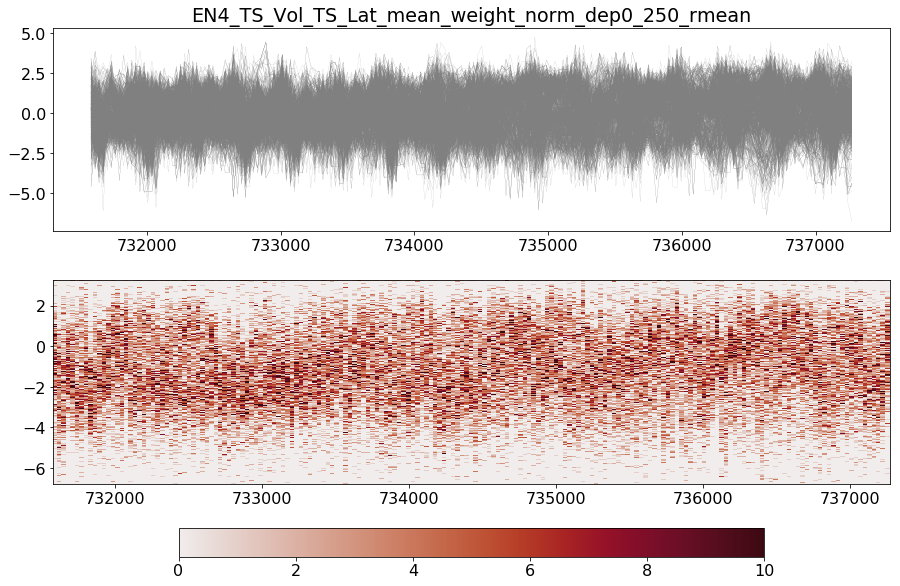

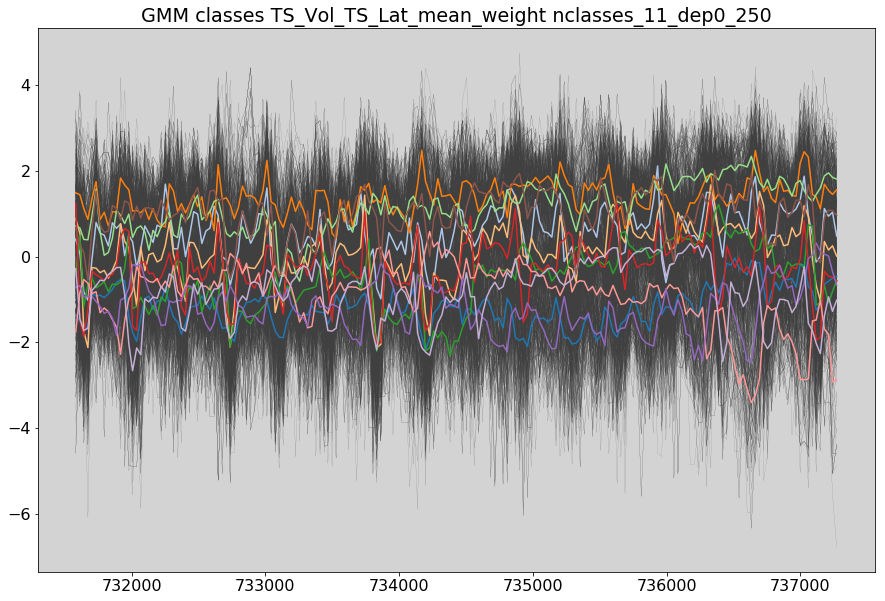

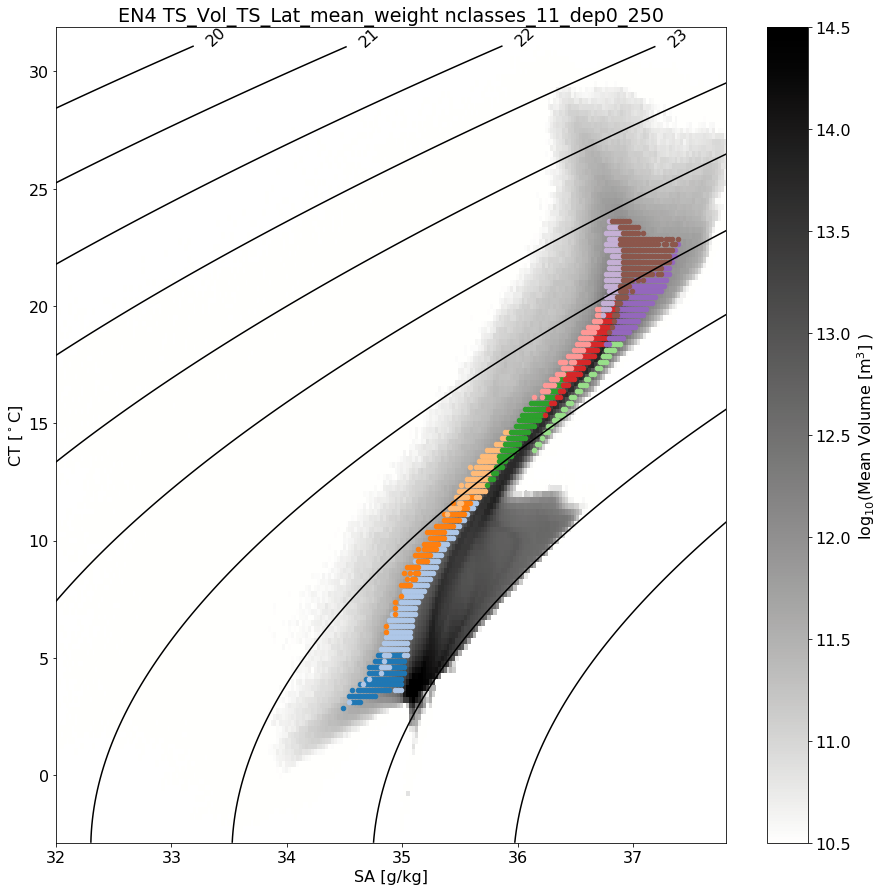

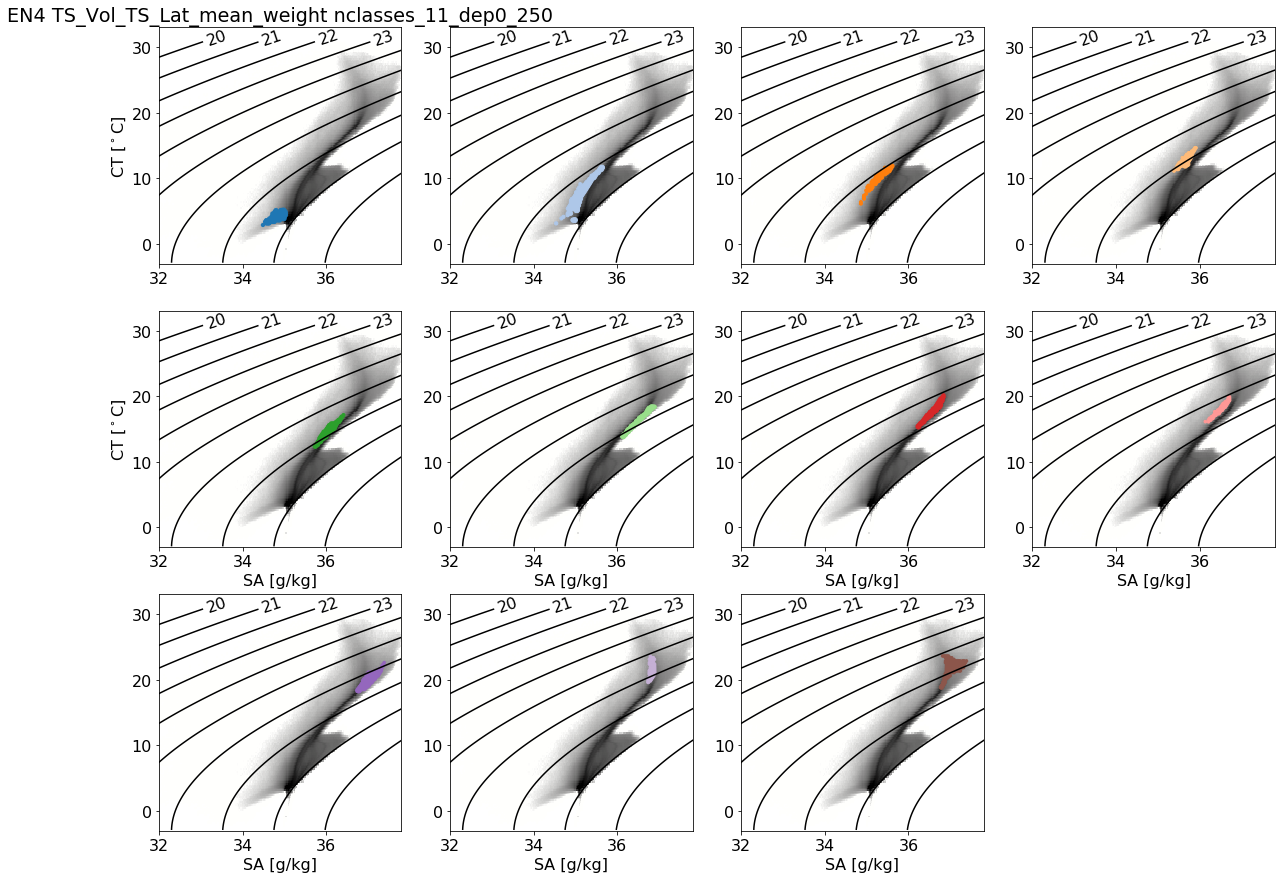

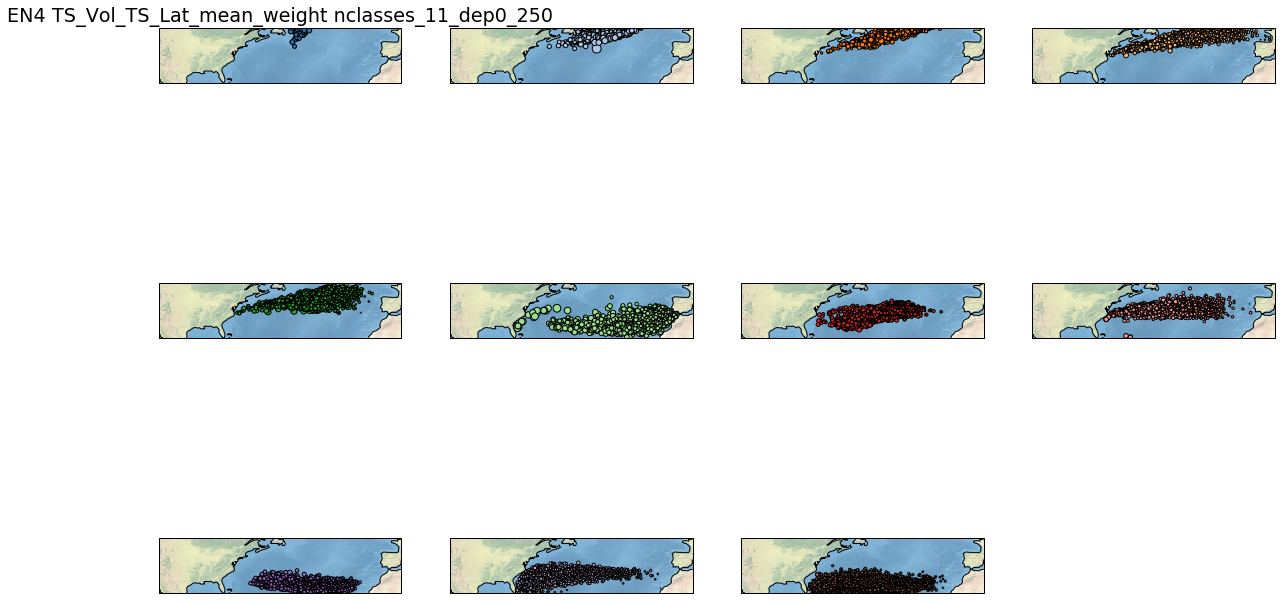

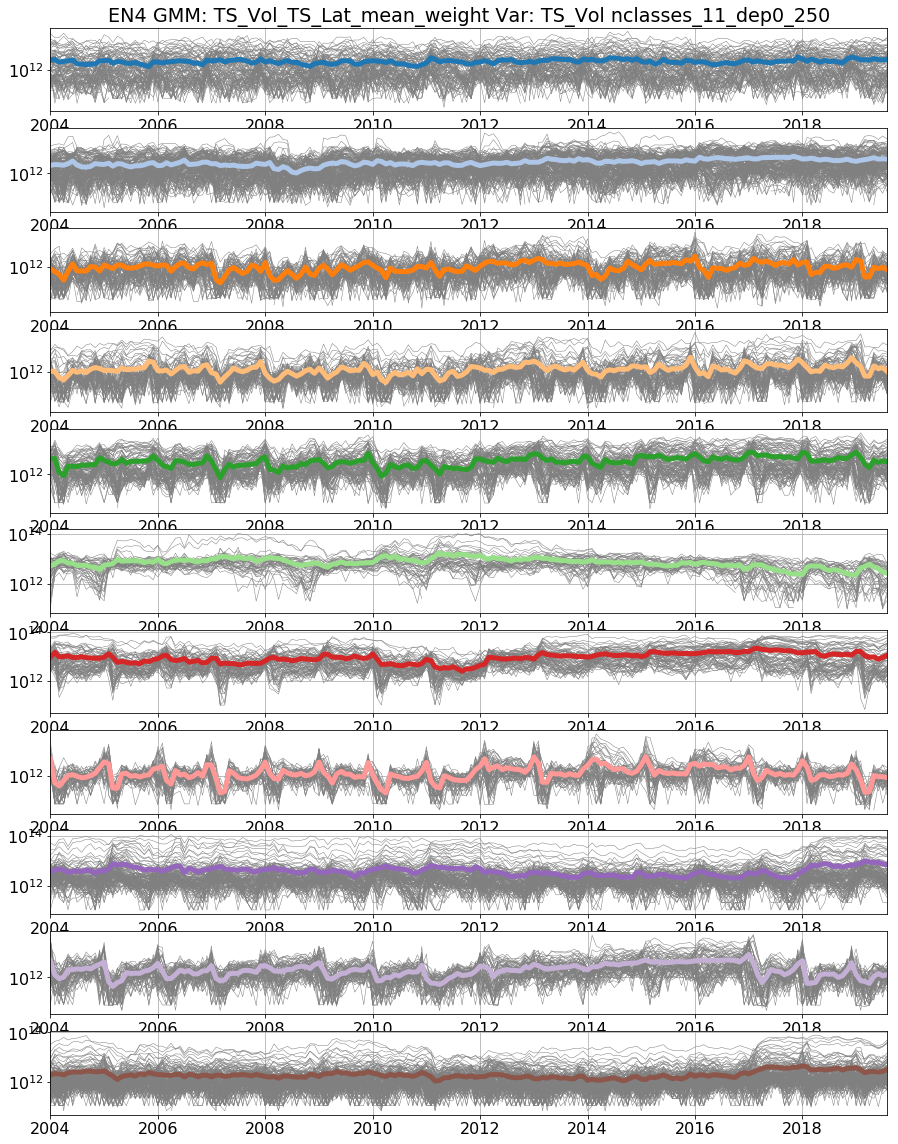

In [69]:
dep_cut_off = [0, 250] # Select depth range
n_data_cut_off = 10 / len(ts_vol['time']) # Select no data cut-off
n_months = 4 # Running mean window size
tr_dset_frac = 1 # Training dataset size: Fraction of full dataset

fig_dir = '~/Dropbox/work_general/projects/CLASS/RAPID2OSNAP/analysis/figs/'

#### Just TS VOL ####
# ts_var = ts_vol['ts_vol'] # 4 month running mean, 10 classes, norm_type='time', calclog='True'
# gmm_var_name = 'TS_Vol'
# # for_gmm = pre_GMM(ts_var, ts_vol['time'], dep_cut_off, n_data_cut_off, tr_dset_frac, fig_dir, gmm_var_name, n_months, rmean=True,  plot=True, norm_type='time', calclog=True, weightit=False)
# for_gmm = pre_GMM(ts_var, ts_vol['time'], dep_cut_off, n_data_cut_off, tr_dset_frac, fig_dir, gmm_var_name, rmean=False,  plot=True, norm_type='time', calclog=True, weightit=False)

#### TS VOL weighted with TS LAT ####
ts_var = ts_vol['ts_vol'].copy() # 4 month running mean, 10 classes, norm_type='time', calclog='True'
WeightVar = ts_vol['ts_lat'].copy()
WeightVar[np.isnan(WeightVar)] = 0
gmm_var_name = 'TS_Vol_TS_Lat_mean_weight'
# for_gmm = pre_GMM(ts_var, ts_vol['time'], dep_cut_off, n_data_cut_off, tr_dset_frac, fig_dir, gmm_var_name, n_months, 
#                   WeightVar, rmean=True,  plot=True, norm_type='time', calclog=True, weightit=True, norm_type_weight='ts')
for_gmm = pre_GMM(ts_var, ts_vol['time'], dep_cut_off, n_data_cut_off, tr_dset_frac, fig_dir, gmm_var_name, 
                  WeightVar, rmean=False,  plot=True, norm_type='time', calclog=True, weightit=True, norm_type_weight='ts')

#### Just TS LAT ####
# ts_var = ts_lat.copy() # 4 month running mean, 10 classes, norm_type='ts', calclog='False'
# ts_var[np.isnan(ts_var)] = 0
# gmm_var_name = 'TS_Lat'
# for_gmm = pre_GMM(ts_var, ts_vol['time'], dep_cut_off, n_data_cut_off, tr_dset_frac, fig_dir, gmm_var_name, n_months, rmean=True,  plot=True, norm_type='ts', calclog=False, weightit=False)

#### Just TS LON ####
# ts_var = ts_lon.copy()
# ts_var[np.isnan(ts_var)] = 0
# gmm_var_name = 'TS_Lon'
# for_gmm = pre_GMM(ts_var, ts_vol['time'], dep_cut_off, n_data_cut_off, tr_dset_frac, fig_dir, gmm_var_name, n_months, rmean=True,  plot=True, norm_type='ts', calclog=False, weightit=False)


# run_BIC(for_gmm, fig_dir)
# 0-250 m = 10 classes
# 0-250 m = 12 classes when using all of Atl north of 25 deg N
# 0-500 m = 11 classes
# 0-1000 m = 13 classes
# 0-6000 m = 15 classes
# 1000-6000 m = 2/3 classes

n_comp = 11 # number of classes in GMM object
plot_col = plt.get_cmap("tab20")

gmm = gmm_fit(for_gmm, n_comp, plot_col, fig_dir)

# plot_col = cmocean.cm.thermal

labels, class_TS_stat = gmm_label(gmm, for_gmm, plot_col, fig_dir)

# plot_class_timeseries(gmm, labels, for_gmm, plot_col, fig_dir, class_TS_stat)

Var = ts_vol['ts_vol'].copy()
Var[Var == 0] = np.nan

fig_title = 'TS_Vol'
line_col = [0.5, 0.5, 0.5] 
# line_col = cmocean.cm.thermal
yax_scale = 'log'

mean_vol_all_classes = plot_ts_class_var_timeseries(gmm, labels, for_gmm, Var, ts_vol['time'], plot_col, line_col, yax_scale, fig_title, fig_dir, 'mean', class_TS_stat)

#### Plot volume anomaly time-series for each class

In [67]:
def SmoothVar(Var, Var_time, n_months):
    
    da = xr.DataArray(Var,
                      dims=('x', 'time'),
                      coords={'time': Var_time})

    r = da.rolling(time=n_months, center=True)
    r_mean = r.mean().dropna('time')

    Var_smth = r_mean.data              
    Var_smth_time = mdates.date2num(r_mean['time'])
    
    return Var_smth, Var_smth_time

In [ ]:
datvec = np.zeros((len(ts_vol['time']), 3))
datnp64 = []

for ii in np.arange(0, len(ts_vol['time']), 1):
    datvec[ii, 0] = mdates.num2date(ts_vol['time'])[ii].year
    datvec[ii, 1] = mdates.num2date(ts_vol['time'])[ii].month
    datvec[ii, 2] = mdates.num2date(ts_vol['time'])[ii].day
    datnp64.append('{:1.0f}-{:02.0f}-{:02.0f}'.format(datvec[ii, 0], datvec[ii, 1], datvec[ii, 2]))

datnp64 = np.array(datnp64, dtype='datetime64')

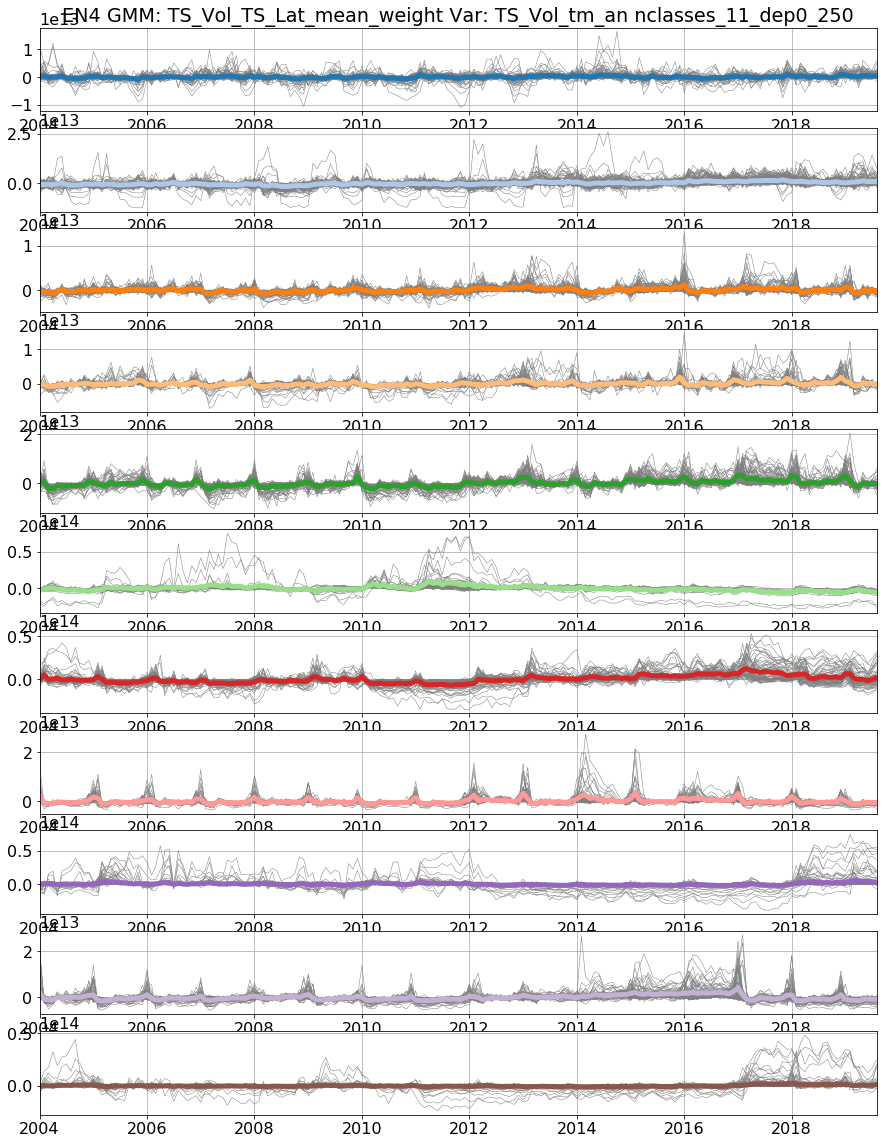

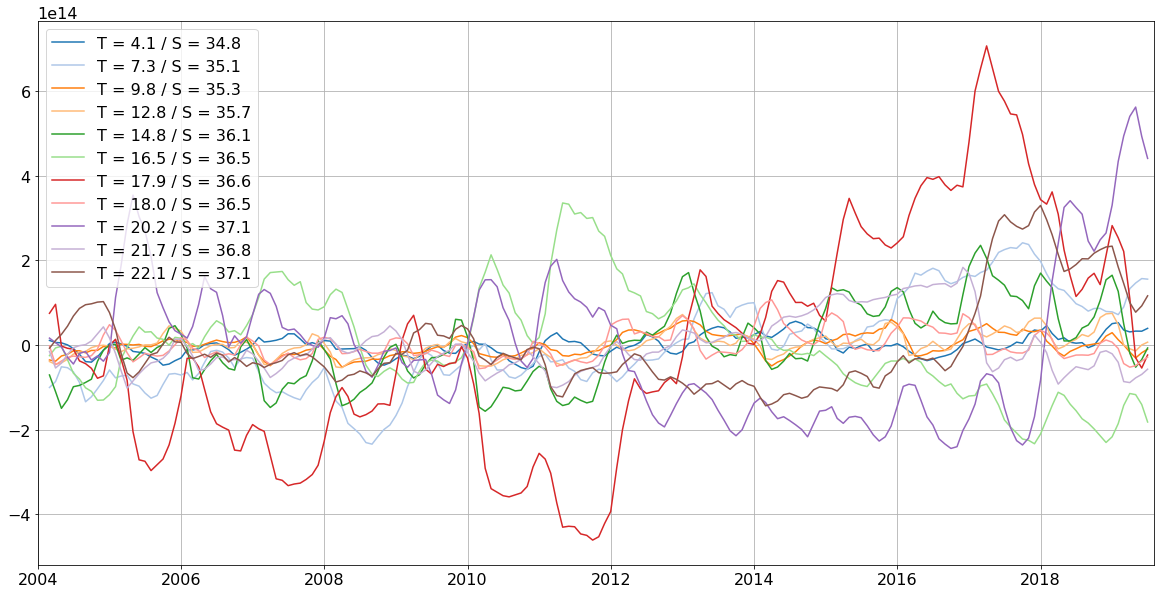

In [70]:
ts_vol_tm_an = ts_vol['ts_vol'] - np.expand_dims(np.nanmean(ts_vol['ts_vol'], axis=2), axis=2)
ts_vol_mm, ts_vol_mm_an = calc_mm_an_3dims(ts_vol['ts_vol'], datvec)

# Var = ts_vol['ts_vol'].copy()
# Var[Var == 0] = np.nan

line_col = [0.5, 0.5, 0.5] 
# line_col = cmocean.cm.thermal
yax_scale = 'linear'

################

fig_title = 'TS_Vol_tm_an'
mean_vol_tm_an_all_classes = plot_ts_class_var_timeseries(gmm, labels, for_gmm, ts_vol_tm_an, ts_vol['time'], plot_col, line_col, yax_scale, fig_title, fig_dir, 'sum', class_TS_stat)

n_months = 4
mean_vol_tm_an_all_classes_smth, time_smth = SmoothVar(mean_vol_tm_an_all_classes, datnp64, n_months) # Use time original dset, it's in the right format

# class_TS_stat['mean_class_T']
srt_idx = np.argsort(class_TS_stat['mean_class_T'])
mean_class_T_srt = class_TS_stat['mean_class_T'][srt_idx]
mean_class_S_srt = class_TS_stat['mean_class_S'][srt_idx]

fig, ax = plt.subplots(figsize=(20, 10))

for ii in np.arange(0, np.shape(mean_vol_tm_an_all_classes)[0], 1):
    ax.plot(time_smth, mean_vol_tm_an_all_classes_smth[ii, :], c = plot_col(ii), 
            label = 'T = {:3.1f} / S = {:3.1f}'.format(mean_class_T_srt[ii], mean_class_S_srt[ii]))

ax.legend()

loc = mdates.AutoDateLocator()
tick_format = mdates.AutoDateFormatter(loc)
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(tick_format)

ax.set_xlim((np.min(ts_vol['time']), np.max(ts_vol['time'])))
ax.grid(True)

################

# fig_title = 'TS_Vol_mm_an'
# mean_vol_mm_an_all_classes = plot_ts_class_var_timeseries(gmm, labels, for_gmm, ts_vol_mm_an, ts_vol['time'], plot_col, line_col, yax_scale, fig_title, fig_dir)

# n_months = 4
# mean_vol_mm_an_all_classes_smth, time_smth = SmoothVar(mean_vol_mm_an_all_classes, dset.time, n_months) # Use time original dset, it's in the right format

# fig, ax = plt.subplots(figsize=(20, 10))

# for ii in np.arange(0, np.shape(mean_vol_mm_an_all_classes)[0], 1):
#     ax.plot(time_smth, mean_vol_mm_an_all_classes_smth[ii, :], c = plot_col[ii], 
#             label = 'T = {:3.1f} / S = {:3.1f}'.format(class_TS_stat['mean_class_T'][ii,0], class_TS_stat['mean_class_S'][ii,0]))

# ax.legend()

# loc = mdates.AutoDateLocator()
# tick_format = mdates.AutoDateFormatter(loc)
# ax.xaxis.set_major_locator(loc)
# ax.xaxis.set_major_formatter(tick_format)

# ax.set_xlim((np.min(ts_vol['time']), np.max(ts_vol['time'])))
# ax.grid(True)

#### Temperature change from transformations

/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


Text(0,0.5,'Temperature Change')

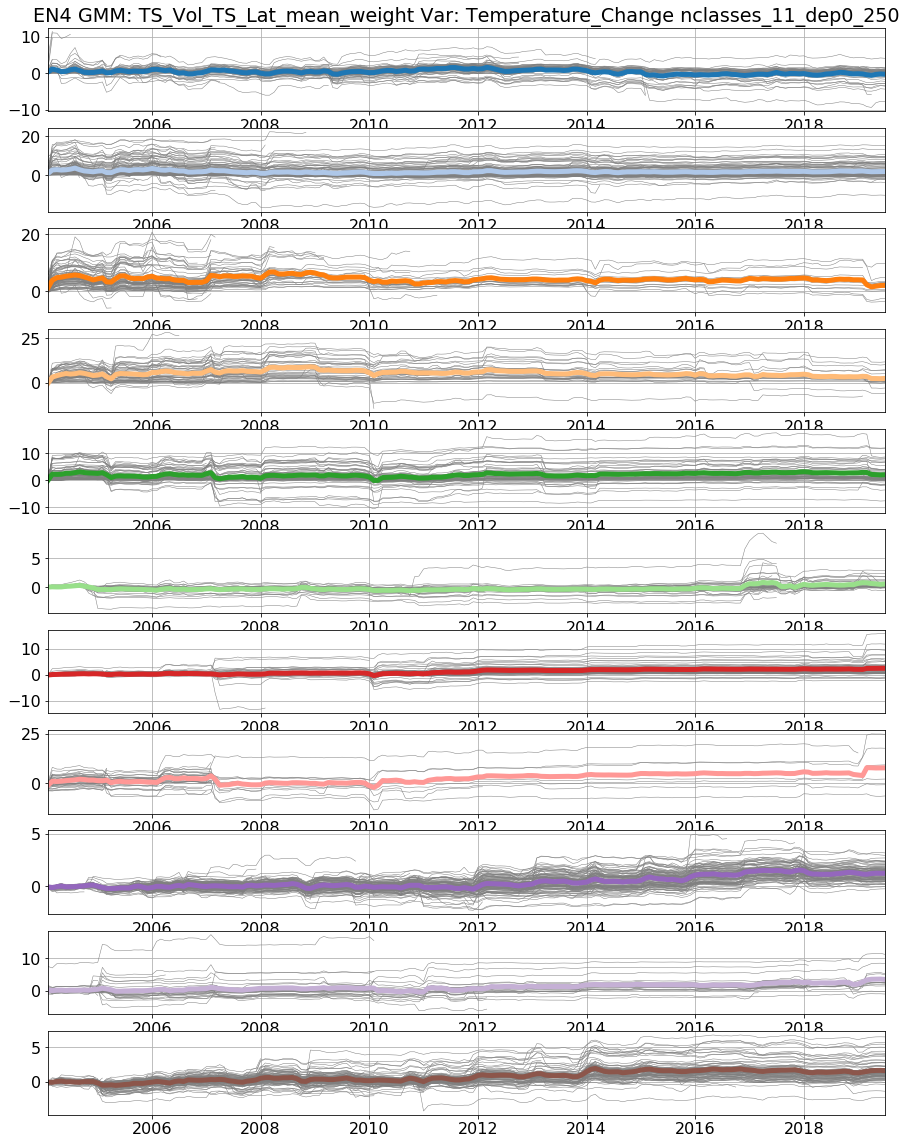

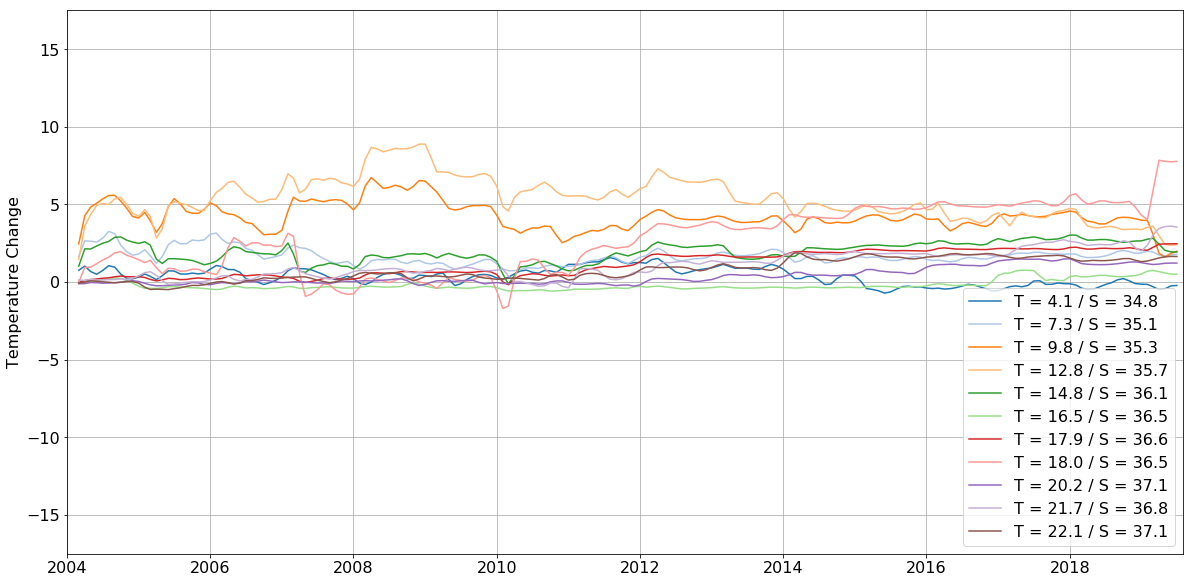

In [84]:
datvec = np.zeros((len(tot_trans['time']), 3))
for ii in np.arange(0, len(tot_trans['time']), 1):
    datvec[ii, 0] = mdates.num2date(tot_trans['time'])[ii].year
    datvec[ii, 1] = mdates.num2date(tot_trans['time'])[ii].month
    datvec[ii, 2] = mdates.num2date(tot_trans['time'])[ii].day
    
# Diathermal transformation
dat_idx = tot_trans['time'] > mdates.datestr2num('2004-01-01')

G_ti = tot_trans['G_ti'].copy()
# G_ti[:, :, -1] = np.nan

G_ti_mm, G_ti_mm_an = calc_mm_an_3dims(G_ti[:, :, dat_idx], datvec[dat_idx, :])

# Volume
ts_vol_nan = ts_vol['ts_vol'].copy()
ts_vol_nan[ts_vol['ts_vol'] == 0] = np.nan

Temperature_Change = np.cumsum((G_ti_mm_an / ts_vol_nan[:, :, 1:-1]) * dT, axis=2) * (30*24*60*60)

fig_title = 'Temperature_Change'
yax_scale = 'linear'
Temperature_Change_all_classes = plot_ts_class_var_timeseries(gmm, labels, for_gmm, Temperature_Change, tot_trans['time'][dat_idx], plot_col, line_col, yax_scale, fig_title, fig_dir, 'mean', class_TS_stat)

n_months = 2
Temperature_Change_smth, time_smth = SmoothVar(Temperature_Change_all_classes, datnp64[1:-1], n_months) # Use time original dset, it's in the right format

# class_TS_stat['mean_class_T']

srt_idx = np.argsort(class_TS_stat['mean_class_T'])
mean_class_T_srt = class_TS_stat['mean_class_T'][srt_idx]
mean_class_S_srt = class_TS_stat['mean_class_S'][srt_idx]

fig, ax = plt.subplots(figsize=(20, 10))

for ii in np.arange(0, np.shape(Temperature_Change_smth)[0], 1):
    ax.plot(time_smth, Temperature_Change_smth[ii, :], c = plot_col(ii), 
            label = 'T = {:3.1f} / S = {:3.1f}'.format(mean_class_T_srt[ii], mean_class_S_srt[ii]))

ax.legend()

loc = mdates.AutoDateLocator()
tick_format = mdates.AutoDateFormatter(loc)
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(tick_format)

ax.set_xlim((np.min(ts_vol['time']), np.max(ts_vol['time'])))
ax.set_ylim((-17.5, 17.5))
ax.grid(True)

ax.set_ylabel('Temperature Change')

#### Salinity change from transformations

/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice
/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice


Text(0,0.5,'Salinity Change')

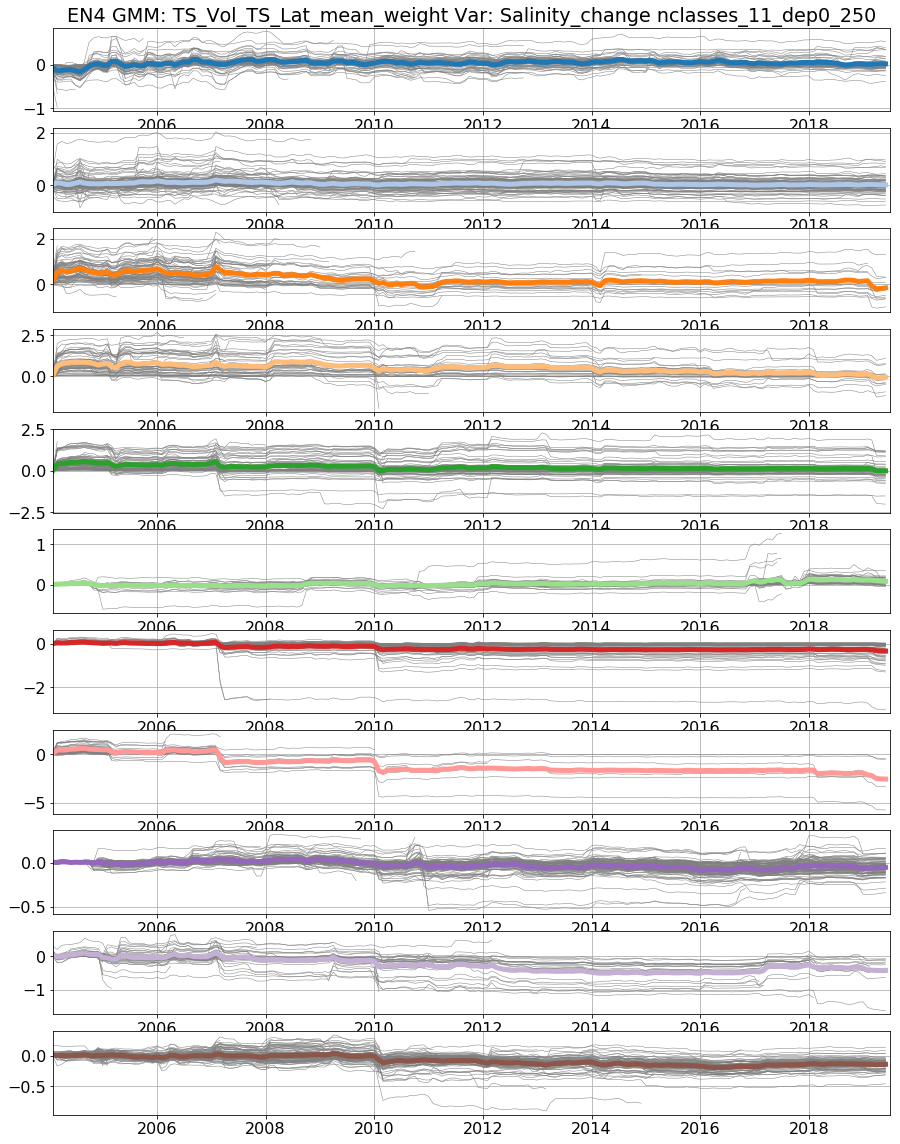

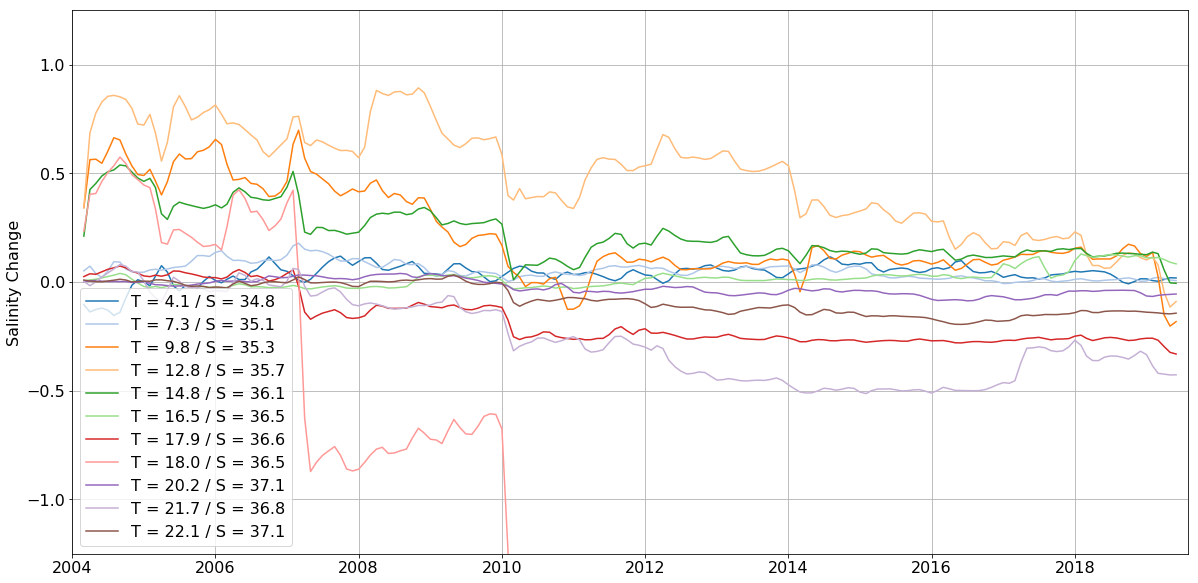

In [85]:
# Diahaline transformation
dat_idx = tot_trans['time'] > mdates.datestr2num('2004-01-01')

G_si = tot_trans['G_si'].copy()
G_si[:, :, -1] = np.nan

G_si_mm, G_si_mm_an = calc_mm_an_3dims(G_si[:, :, dat_idx], datvec[dat_idx, :])

# Volume
ts_vol_nan = ts_vol['ts_vol'].copy()
ts_vol_nan[ts_vol['ts_vol'] == 0] = np.nan

Salinity_Change = np.cumsum((G_si_mm_an / ts_vol_nan[:, :, 1:-1]) * dS, axis=2) * (30*24*60*60)

fig_title = 'Salinity_change'
yax_scale = 'linear'
Salinity_Change_all_classes = plot_ts_class_var_timeseries(gmm, labels, for_gmm, Salinity_Change, tot_trans['time'][dat_idx], plot_col, line_col, yax_scale, fig_title, fig_dir, 'mean', class_TS_stat)

n_months = 2
Salinity_Change_all_classes_smth, time_smth = SmoothVar(Salinity_Change_all_classes, datnp64[1:-1], n_months) # Use time original dset, it's in the right format

# class_TS_stat['mean_class_T']

srt_idx = np.argsort(class_TS_stat['mean_class_T'])
mean_class_T_srt = class_TS_stat['mean_class_T'][srt_idx]
mean_class_S_srt = class_TS_stat['mean_class_S'][srt_idx]

fig, ax = plt.subplots(figsize=(20, 10))

for ii in np.arange(0, np.shape(Salinity_Change_all_classes_smth)[0], 1):
    ax.plot(time_smth, Salinity_Change_all_classes_smth[ii, :], c = plot_col(ii), 
            label = 'T = {:3.1f} / S = {:3.1f}'.format(mean_class_T_srt[ii], mean_class_S_srt[ii]))

ax.legend()

loc = mdates.AutoDateLocator()
tick_format = mdates.AutoDateFormatter(loc)
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(tick_format)

ax.set_xlim((np.min(ts_vol['time']), np.max(ts_vol['time'])))
ax.set_ylim((-1.25, 1.25))
ax.grid(True)

ax.set_ylabel('Salinity Change')